# Parallel United Nations documents dataset

Let's use the United Nations protocol dataset.

https://conferences.unite.un.org/uncorpus/

In [1]:
import re
import numpy as np
import pickle
import pandas as pd
from bs4 import BeautifulSoup
import urllib
import codecs
import os,glob
import glob
import re

from matplotlib import pyplot as plt

#natasha Russian word tokenizer
from razdel import tokenize

#Chienese word tokenizer
import jieba

### Preprocessing

In [3]:
# path_ru = r'D:\ml\umcorpus-v1\UM-Corpus\data\Bilingual\News\translated\news_ru.txt'
# path_zh = r'D:\ml\umcorpus-v1\UM-Corpus\data\Bilingual\News\translated\news_zh.txt'
# output_ru = r'D:\ml\preprocessed\news_ru.txt'
# output_zh = r'D:\ml\preprocessed\news_zh.txt'
# lines_to_process = 395000

path_ru = r'D:\ml\UNv1.0.ru-zh.tar.gz\ru-zh\UNv1.0.ru-zh.ru'
path_zh = r'D:\ml\UNv1.0.ru-zh.tar.gz\ru-zh\UNv1.0.ru-zh.zh'
output_ru = r'D:\ml\preprocessed\un_ru.txt'
output_zh = r'D:\ml\preprocessed\un_zh.txt'
lines_to_process = 5000000

dir_to_merge = r'D:\ml\preprocessed'
merged_ru = r'D:\ml\merged\corpus2_ru.txt'
merged_zh = r'D:\ml\merged\corpus2_zh.txt'

dir_to_merge = r'D:\ml\news_books'
merged_ru = r'D:\ml\b\merged\news_books_3_ru.txt'
merged_zh = r'D:\ml\b\merged\news_books_3_zh.txt'

## числа оставим, занижать кейс не будем
pattern_ru = re.compile(r'[a-zA-Z\.\(\)\[\]\/\-\:!?\<\>;•\"\'«»——,]+')
pattern_zh = re.compile(r'[a-zA-Z\(\)\[\]\s\/\-\:！？｡。•＂＃＄％＆＇（）＊＋，－／：；＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣､、〃》「」『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰〾〿–—‘’‛“”„‟…‧﹏.．]+')

In [5]:
ru_sentence_len = []

with open(path_ru, mode='r', encoding='utf-8') as input_ru:
    count = 0
    while True:
        count+=1
        line_ru = re.sub(pattern_ru, '', input_ru.readline()).strip()
        sentence_length = len(line_ru.split())
        ru_sentence_len.append(sentence_length)
        
        if count == lines_to_process:
            break
        #print(line_ru, sentence_length)
        #break        
            
print("total:", count)

KeyboardInterrupt: 

(array([ 77., 566., 864., 662., 894., 697., 658., 670., 510., 463., 565.,
        626., 661., 670., 759., 757., 799., 804., 847., 871., 859., 874.,
        810., 823., 895., 838., 750., 690., 697., 636., 559., 591., 582.,
        453., 495., 446., 415., 425., 346., 331., 357., 307., 275., 233.,
        210., 220., 183., 203., 174., 145., 143., 142., 111., 127., 100.,
         90.,  92.,  70.,  81.,  57.,  67.,  46.,  53.,  46.,  32.,  37.,
         24.,  43.,  25.,  24.,  21.,  19.,  21.,  17.,  23.,  18.,  12.,
         11.,  12.,  12.,  10.,  13.,   4.,   8.,   5.,   8.,   7.,   8.,
          4.,   5.,   4.,   8.,   2.,   5.,   8.,   2.,   5.,   7.,   3.,
          3.]),
 array([ 0.  ,  0.99,  1.98,  2.97,  3.96,  4.95,  5.94,  6.93,  7.92,
         8.91,  9.9 , 10.89, 11.88, 12.87, 13.86, 14.85, 15.84, 16.83,
        17.82, 18.81, 19.8 , 20.79, 21.78, 22.77, 23.76, 24.75, 25.74,
        26.73, 27.72, 28.71, 29.7 , 30.69, 31.68, 32.67, 33.66, 34.65,
        35.64, 36.63, 37.62, 38.61

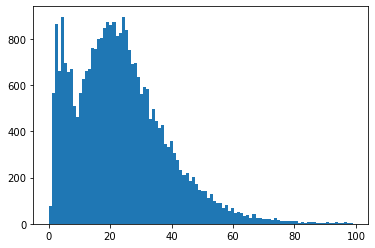

In [57]:
plt.hist([x for x in ru_sentence_len if x <100], bins=100)

Видимо, нужно почистить от формальных повторяющихся данных. Посмотрим на них.

In [58]:
short_sents = []

with open(path_ru, mode='r', encoding='utf-8') as input_ru:
    count = 0
    while True:
        count+=1
        line_ru = re.sub(pattern_ru, '', input_ru.readline()).strip()
        sentence_length = len(line_ru.split())
        
        if sentence_length < 20:
            short_sents.append(line_ru.lower())
        
        if count == 30000:
            break    
            
print("total:", count)

total: 30000


In [59]:
len(short_sents)

13420

In [60]:
df = pd.Series(data=short_sents)

In [61]:
a = df.value_counts().reset_index(name='count')

In [62]:
a.head(20)

,index,count
0,содержание,78
1,,77
2,объединенных наций,54
3,комитет по использованию космического,41
4,пункты страница,37
5,записка секретариата,25
6,примечания,25
7,приложение,24
8,введение,18
9,организация объединенных наций,18


Удалим дубликаты.

In [6]:
total_ru = []
first_numbers = re.compile(r'^[0-9,\.]+')
last_punct = re.compile(r'[,\.]+$')
multiple_spaces = re.compile(r'\s+')

with open(path_ru, mode='r', encoding='utf-8') as input_ru:
    count = 0
    while True:
        count+=1
        line_ru = re.sub(pattern_ru, '', input_ru.readline()).strip()
        line_ru = re.sub(last_punct, '', line_ru).strip()
        line_ru = re.sub(first_numbers, '', line_ru).strip()
        line_ru = re.sub(multiple_spaces, ' ', line_ru).strip()
        #line_ru = line_ru.lower()
        
        total_ru.append(line_ru + ".")
        
        if count == lines_to_process:
            break     
            
print("total:", count)

total: 5000000


In [64]:
total_ru

['РЕЗОЛЮЦИЯ 918 1994.',
 'Совет Безопасности.',
 'подтверждая все свои предыдущие резолюции о ситуации в Руанде в частности свою резолюцию 872 1993 от 5 октября 1993 года в соответствии с которой он учредил Миссию Организации Объединенных Наций по оказанию помощи Руанде МООНПР свою резолюцию 909 1994 от 5 апреля 1994 года в которой он продлил мандат МООНПР до 29 июля 1994 года и свою резолюцию 912 1994 от 21 апреля 1994 года в соответствии с которой он изменил мандат МООНПР.',
 'ссылаясь на заявления Председателя сделанные им от имени Совета Безопасности 7 апреля 1994 года 199416 и 30 апреля 1994 года 199421.',
 'рассмотрев доклад Генерального секретаря от 13 мая 1994 года 1994565.',
 'подтверждая свою резолюцию 868 1993 от 29 сентября 1993 года о безопасности операций Организации Объединенных Наций.',
 'высоко оценивая усилия Организации африканского единства ОАЕ и ее органов а также усилия содействующей стороны Танзании по оказанию дипломатической политической и гуманитарной поддержк

In [7]:
total_zh = []
first_numbers = re.compile(r'^[0-9,\.]+')

with open(path_zh, mode='r', encoding='utf-8') as input_zh:
    count = 0
    while True:
        count+=1
        line_zh = re.sub(pattern_zh, '', input_zh.readline()).strip()        
        line_zh = re.sub(first_numbers, '', line_zh).strip()
        total_zh.append(line_zh + "。")
        
        if count == lines_to_process:
            break
            
print("total:", count)

total: 5000000


In [66]:
total_zh

['第9181994号决议。',
 '安全理事会。',
 '重申其以往关于卢旺达局势的所有决议特别是成立联合国卢旺达援助团联卢援助团的1993年10月5日第8721993号决议延长联卢援助团任务期限至1994年7月29日的1994年4月5日第9091994号决议以及调整联卢援助团的任务规定的1994年4月21日第9121994号决议。',
 '回顾安理会主席以安理会名义在1994年4月7日发表的声明199416和在1994年4月30日发表的声明199421。',
 '审议了1994年5月13日秘书长的报告1994565。',
 '重申其1993年9月29日关于联合国行动安全的第8681993号决议。',
 '赞扬非洲统一组织及其机关和坦桑尼亚调解人努力提供外交政治和人道主义支助以期执行安理会的有关决议。',
 '深为关切卢旺达局势已造成成千上万的无辜平民包括妇女与儿童的死亡卢旺达极大比例的人口在国内流离失所以及难民大批涌向邻国构成巨大的人道主义危机。',
 '对不断传来的卢旺达境内发生有计划普遍公然违反国际人道主义法行为和其他侵犯生命和财产权利的报告再次表示震惊。',
 '在这方面回顾屠杀一个种族集团的成员以图将该集团整个或部分消灭构成根据国际法应受惩罚的罪行。',
 '促请所有各方立即停止特别是通过大众媒体进行任何煽动暴乱或种族仇恨的行为。',
 '又回顾安理会曾请秘书长收集有关造成卢旺达和布隆迪两位总统死难悲惨事件的罪责的资料。',
 '进一步回顾安理会曾请秘书长建议如何调查冲突期间严重违反国际人道主义法行为的报告。',
 '强调迫切需要采取协调的国际行动以减轻卢旺达人民的苦难并协助恢复卢旺达境内的和平在这方面欣见联合国与非统组织以及该区域各国特别是阿鲁沙和平进程的调解人合作。',
 '希望在这方面扩大联卢援助团的人道主义任务并强调重视各方对成功全面实施这一任务的支持与合作。',
 '重申承诺维护卢旺达的统一和领土完整。',
 '认识到卢旺达人民负有民族和解与本国重建的根本责任。',
 '深感不安的是冲突造成人民巨大的苦难并忧虑卢旺达局势的延续对区域内的和平与安全构成威胁。',
 '。',
 '要求冲突各方立即停止敌对行为同意停火并终止席卷卢旺达的盲目暴乱和杀戮。',
 '欣见秘书长1994年5月13日的报告1994565。',
 '决定在现有资源范围内扩大第9

In [8]:
corpus_df = pd.DataFrame({"ru":total_ru,"zh":total_zh})

In [9]:
corpus_df.drop_duplicates(subset="ru", keep="last", inplace=True)

In [10]:
corpus_df.shape

(3849100, 2)

(array([ 2768.,  8639., 10146., 11696., 11646., 10606., 10921.,  9910.,
         9450.,  9504.,  9718., 10005., 10558., 11137., 11497., 11668.,
        11933., 12015., 11972., 11651., 11638., 11397., 11233., 10721.,
        10399.,  9944.,  9627.,  9011.,  8661.,  8076.,  7732.,  7266.,
         6785.,  6499.,  5927.,  5672.,  5272.,  4911.,  4461.,  4272.,
         3861.,  3587.,  3220.,  3037.,  2735.,  2505.,  2498.,  2168.,
         2066.,     0.,  1847.,  1676.,  1583.,  1454.,  1336.,  1259.,
         1193.,  1072.,   949.,   902.,   834.,   786.,   722.,   664.,
          601.,   557.,   524.,   460.,   413.,   377.,   346.,   374.,
          297.,   326.,   283.,   287.,   237.,   238.,   205.,   203.,
          201.,   166.,   175.,   162.,   136.,   136.,   124.,   107.,
          122.,   104.,   121.,   106.,    87.,    79.,    83.,    86.,
           83.,    57.,    61.,    54.]),
 array([ 1.  ,  1.98,  2.96,  3.94,  4.92,  5.9 ,  6.88,  7.86,  8.84,
         9.82, 10.8 , 1

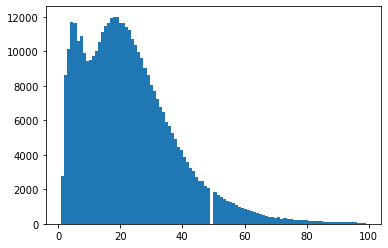

In [70]:
ru_sentence_len = []

for i in range(corpus_df.shape[0]):
    line_ru = corpus_df["ru"].iloc[i]
    sentence_length = len(line_ru.split())
    ru_sentence_len.append(sentence_length)
#     print(line_ru, sentence_length)
            
plt.hist([x for x in ru_sentence_len if x <100], bins=100)

In [71]:
# len(ru_sentence_len)

In [11]:
#corpus_df["ru_len"] = pd.Series(ru_sentence_len)
#fix
corpus_df["ru_len"] = corpus_df["ru"].str.split().str.len()

In [12]:
corpus_df.iloc[0:15]

,ru,zh,ru_len
0,РЕЗОЛЮЦИЯ 918 1994.,第9181994号决议。,3
2,подтверждая все свои предыдущие резолюции о си...,重申其以往关于卢旺达局势的所有决议特别是成立联合国卢旺达援助团联卢援助团的1993年10月5...,73
3,ссылаясь на заявления Председателя сделанные и...,回顾安理会主席以安理会名义在1994年4月7日发表的声明199416和在1994年4月30日...,21
4,рассмотрев доклад Генерального секретаря от 13...,审议了1994年5月13日秘书长的报告1994565。,10
5,подтверждая свою резолюцию 868 1993 от 29 сент...,重申其1993年9月29日关于联合国行动安全的第8681993号决议。,16
6,высоко оценивая усилия Организации африканског...,赞扬非洲统一组织及其机关和坦桑尼亚调解人努力提供外交政治和人道主义支助以期执行安理会的有关决议。,28
7,будучи глубоко обеспокоен тем что ситуация в Р...,深为关切卢旺达局势已造成成千上万的无辜平民包括妇女与儿童的死亡卢旺达极大比例的人口在国内流离...,46
8,вновь выражая свою тревогу в связи с продолжаю...,对不断传来的卢旺达境内发生有计划普遍公然违反国际人道主义法行为和其他侵犯生命和财产权利的报告...,30
9,напоминая в этой связи о том что убийство член...,在这方面回顾屠杀一个种族集团的成员以图将该集团整个或部分消灭构成根据国际法应受惩罚的罪行。,26
10,самым настоятельным образом призывая все сторо...,促请所有各方立即停止特别是通过大众媒体进行任何煽动暴乱或种族仇恨的行为。,20


Запишем в файл.

In [13]:
count = 0
with open(output_ru, mode='w', encoding='utf-8') as out_ru, open(output_zh, mode='w', encoding='utf-8') as out_zh:
    for i in range(corpus_df.shape[0]):
        ru_len = corpus_df["ru_len"].iloc[i]
        
        if (ru_len>2) & (ru_len<45):
            out_ru.write(corpus_df["ru"].iloc[i] + "\n")
            out_zh.write(corpus_df["zh"].iloc[i] + "\n")
            count += 1

print("total:", count)

total: 3433581


Посмотрел датасет. Предложения сложные, длинные, многострочные. Однако каждую строку можно рассматривать как отдельное предложение. Попробую исправить пунктуацию на конце и заглавную букву.

In [75]:
# output_ru = r'D:\ml\UNv1.0.ru-zh.tar.gz\ru-zh\output_ru_sent.txt'
# output_zh = r'D:\ml\UNv1.0.ru-zh.tar.gz\ru-zh\output_zh_sent.txt'

# with open(output_ru, mode='w', encoding='utf-8') as out_ru, open(output_zh, mode='w', encoding='utf-8') as out_zh:
#     for i in range(corpus_df.shape[0]):
#         ru_len = corpus_df["ru_len"].iloc[i]
        
#         if (ru_len>5) & (ru_len<50):
#             out_ru.write(corpus_df["ru"].iloc[i] + "\n")
#             out_zh.write(corpus_df["zh"].iloc[i] + "\n")

Проверим выровненность

In [76]:
import random

def print_random():
    count = 0
    rnd = random.randint(0,1233)
    with open(output_ru, mode='r', encoding='utf-8') as out_ru, open(output_zh, mode='r', encoding='utf-8') as out_zh:
        while True:
            line_ru = out_ru.readline()
            line_zh = out_zh.readline()
            count+=1
            if count==rnd:
                print(line_ru)
                print(line_zh)
                break

print_random()
print_random()
print_random()
print_random()
print_random()

Этот микроспутник представляет собой недорогостоящую платформу которая имеет умеренно продолжительный срок службы и в будущем может быть модифицирована.

它是一个低成本平台运转寿命较长且能在今后进一步发展。

В частности в нем представлена подробная информация о разработанных самими участниками планах осуществления ряда проектов регионального уровня представляющих определенный интерес.

报告特别详细描述了由参加者自己拟订的若干与该地区有关并涉及整个地区的项目计划。

В целях сопоставления ученые обследовали также прилегающую зону вдоль половины эклиптики плоскости орбиты Земли вокруг Солнца.

为了进行比较科学家们还调查了沿地球绕太阳行走的半黄道平面的伴生区。

После завершения финансового года в сотрудничестве с различными специалистами в области радиолокационных и оптических наблюдений и исследований велась работа по уточнению прежних расчетов.

在财政年度结束后还与各专业无线电及光学观测人员和研究人员共同合作进一步校正原来的计算数字。

просит Генерального секретаря как рекомендовано в его докладе и в качестве первого этапа немедленно вновь разместить в Руанде военных наблюдателей МООНПР находящихся в настоящее время в Найроби и 

### Merge

In [9]:
import os
import glob

for f in [filenames for (dirpath, dirnames, filenames) in os.walk(dir_to_merge)]:
    types = ['\*_ru.txt', '\*_zh.txt']
    ru = []
    zh = []
    
    print(f)
    
    #print(path + f)
    files = glob.glob(dir_to_merge + types[0])        
    ru.extend(files)
    
    #print(path + f)
    files = glob.glob(dir_to_merge + types[1])        
    zh.extend(files)

['chekhov_futlar_ru.txt', 'chekhov_futlar_zh.txt', 'idiot_ru.txt', 'idiot_zh.txt', 'izergil_ru.txt', 'izergil_zh.txt', 'lu_xun_ben_ye_ru.txt', 'lu_xun_ben_ye_zh.txt', 'mumu_ru.txt', 'mumu_zh.txt', 'stal_ru.txt', 'stal_zh.txt', 'tolst_ru.txt', 'tolst_zh.txt', 'turgenev_love_ru.txt', 'turgenev_love_zh.txt', 'z_news_ru.txt', 'z_news_zh.txt']


In [10]:
for r,z in zip(ru,zh):
    print(r,z)

D:\ml\news_books\chekhov_futlar_ru.txt D:\ml\news_books\chekhov_futlar_zh.txt
D:\ml\news_books\idiot_ru.txt D:\ml\news_books\idiot_zh.txt
D:\ml\news_books\izergil_ru.txt D:\ml\news_books\izergil_zh.txt
D:\ml\news_books\lu_xun_ben_ye_ru.txt D:\ml\news_books\lu_xun_ben_ye_zh.txt
D:\ml\news_books\mumu_ru.txt D:\ml\news_books\mumu_zh.txt
D:\ml\news_books\stal_ru.txt D:\ml\news_books\stal_zh.txt
D:\ml\news_books\tolst_ru.txt D:\ml\news_books\tolst_zh.txt
D:\ml\news_books\turgenev_love_ru.txt D:\ml\news_books\turgenev_love_zh.txt
D:\ml\news_books\z_news_ru.txt D:\ml\news_books\z_news_zh.txt


In [11]:
import re
pat_ = re.compile(r"[a-zA-Z]+")

total_ru = []
first_numbers = re.compile(r'^[0-9,\.]+')
last_punct = re.compile(r'[,\.]+$')
multiple_spaces = re.compile(r'\s+')
pattern_ru = re.compile(r'[a-zA-Z\.\(\)\[\]\/\-\:!?\<\>;•\"\'«»——,]+')
pattern_zh = re.compile(r'[a-zA-Z\(\)\[\]\s\/\-\:｡。•＂＃＄％＆＇（）＊＋，－／：；＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣､、〃》「」『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰〾〿–—‘’‛“”„‟…‧﹏.．]+')

with open(merged_ru, mode="w", encoding="utf-8") as out_ru, \
     open(merged_zh, mode="w", encoding="utf-8") as out_zh:
    for r,z in zip(ru,zh):
        with open(r, mode="r", encoding="utf-8") as in_ru, open(z, mode="r", encoding="utf-8") as in_zh:
            lines_ru = in_ru.readlines()
            for line_ru in lines_ru:
                line_zh = in_zh.readline()
                
                line_ru = re.sub(pattern_ru, '', line_ru).strip()
                line_ru = re.sub(last_punct, '', line_ru).strip()
                line_ru = re.sub(first_numbers, '', line_ru).strip()
                line_ru = re.sub(multiple_spaces, ' ', line_ru).strip()
                line_ru = line_ru + "."
                
                line_zh = re.sub(pattern_zh, '', line_zh).strip()        
                line_zh = re.sub(first_numbers, '', line_zh).strip()
                line_zh = line_zh + "。"
                
                words_number = len(line_ru.split())
                
                if (words_number > 5):
                    out_ru.write(line_ru.strip() + "\n")
                    out_zh.write(line_zh.strip() + "\n")